# 引入包
本来想使用webdriver，但是爬到一半总是报错，未能解决，遂放弃。

In [1]:
import requests
import re 
import pymysql
from bs4 import BeautifulSoup as bs
# selenium用于模拟人浏览
# from selenium import webdriver  
# from selenium.webdriver.firefox.options import Options


# 定义将数据存入数据库的函数
需先设置好数据库，分别存入题目，网址，发布部门，发布时间，浏览量，文本内容，图片链接

In [2]:
# 将数据存入数据库
def savenews(title,url,department,publishdate,count,content,piclinks):
    #pysql.connect(数据库URL，用户名，密码，数据库名)
    db = pymysql.connect(host="127.0.0.1", user="root", passwd="123456", db="cucnews", port=3306,charset="utf8")

    cursor = db.cursor()
    try:
        cursor.execute('INSERT INTO news2(title,url,department,publishdate,count,content,piclinks) VALUES(%s,%s,%s,%s,%s,%s,%s)', (title,url,department,publishdate,count,content,piclinks))
        db.commit()
    except Exception as e:
        print('1错误类型是',e.__class__.__name__)
        print('错误明细是',e)
        db.rollback()

    db.close()



# 定义爬取信息的函数
为了防止报错中断，将错误设置为返回0，
我们登录网站后，对需要爬取的信息右键“检查”，可以发现其属性类别，使用soup进行捕捉。
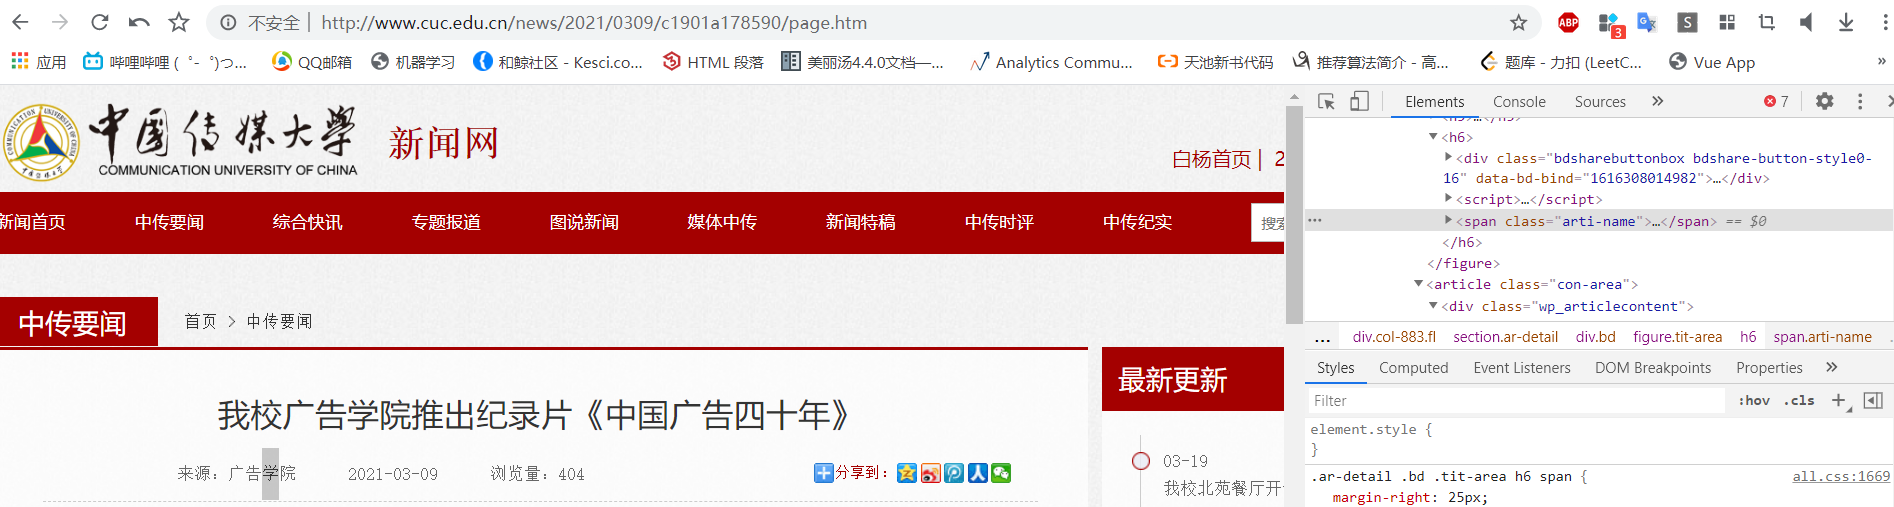

实际爬取过程中多次使用了find函数，功能为返回索引值。我们先使用soup对文本数据进行捕捉，对于发布部门，发布时间，浏览量等内容存在于同一块的，使用find利用索引取分开，并分别保存

In [3]:
def parsecontent(newsurl):
    try:
#         if newsurl == '':
#             url = "http://www.cuc.edu.cn/news/2021/0309/c1901a178590/page.htm"
#         else:
#             url = newsurl
        
        
#         option = webdriver.ChromeOptions()
#         option.add_argument('headless') # 设置不打开浏览器
#         # executable_path是谷歌浏览器的驱动路径，请确保已安装
#         bro = webdriver.Chrome(options = option,executable_path=r"F:\Cent\CentBrowser\Application\chromedriver.exe")
#         bro.get(newsurl)
        r = requests.get(newsurl) #获取网站返回内容
        rt = r.content # 获取文本
        rh = str(rt,"utf-8") #转为字符串，utf8格式
#         html_source = bro.page_source
        soup = bs(rh,"html.parser") #使用soup获取
        
        #新闻标题
        h1 = soup.find_all("h1") #获取新闻标题h1
        #检查时发现信息内容为arti-name，见上图
        info = soup.find_all("span",attrs={"class":"arti-name"})
        infotxt = info[0].get_text()       
        department = infotxt[infotxt.find('来源：')+3:infotxt.find('20')] #发表部门
        newsdate = infotxt[infotxt.find('20'):infotxt.find('20')+10] #发表日期
        rn = re.compile('[\u4e00-\u9fa5]+')#正则表达式为取中文，可以去掉回车
        dep = rn.findall(department)
        
        countinfo = soup.find_all("span",attrs={"class":"WP_VisitCount"})
        count = countinfo[0].get_text()
        # 将图片地址插入piclinks
        all_image = soup.find("article",attrs={"class":"con-area"}).find_all('img')
        piclinks = ''
        for i in range(len(all_image)):
            if all_image[i] != '':
                link = 'http://www.cuc.edu.cn/_upload/'+str(all_image[i])[str(all_image[i]).find('src="')+14:str(all_image[i]).find('.')+4]
                piclinks = piclinks + link + ' '
        
        contentinfo = soup.find_all("div",attrs={"class":"wp_articlecontent"})
        content = contentinfo[0].get_text()
        
#         bro.quit()
    except:
        return 0,0,0,0,0
    return dep[0],newsdate,count,piclinks,content


# mian 运行并存入数据库
这里先访问至111是因为运行时110页第4篇文章格式有问题，导不进去数据库，遂手动放弃。
print（i）是计数，方便发现错误。

In [4]:
urlpath="http://www.cuc.edu.cn/news/1901/list"
try:
    for i in range(1,111):
        url=urlpath+str(i)+".htm"
        #print(url)
        r=requests.get(url)
        code=r.encoding
        content=r.content
        rt=str(content,"utf-8")
        soup=bs(rt,"html.parser")
        href=soup.find_all("h3",attrs={'class','tit'})
        for h in href:
            newsurl=h.find_all('a')
            urllen=str(newsurl[0]).find('target')
            newsurl=str(newsurl[0])[9:urllen-2]
            newsurl="http://www.cuc.edu.cn"+newsurl
            title=h.get_text()
#             print(title) 
#             print("------Save Start!---------")
            department,date,count,piclinks,content = parsecontent(newsurl)
            savenews(title,newsurl,department,date,count,content,piclinks)
#             print("------Save Sucess！---------")
            #savenews(title,newsurl)
        print(i)
except Exception as e:
    print('3错误类型是',e.__class__.__name__)
    print('错误明细是',e)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
3错误类型是 IndexError
错误明细是 list index out of range


In [ ]:
# 内容同上，只是为了避免错误
下午有一个错误：
1错误类型是 DataError
错误明细是 (1406, "Data too long for column 'content' at row 1")
原因在于数据库给的content存储长度不足，这里只有这一篇有问题，就不再去更改长度了。

In [5]:
urlpath="http://www.cuc.edu.cn/news/1901/list"
try:
    for i in range(111,582):
        url=urlpath+str(i)+".htm"
        #print(url)
        r=requests.get(url)
        code=r.encoding
        content=r.content
        rt=str(content,"utf-8")
        soup=bs(rt,"html.parser")
        href=soup.find_all("h3",attrs={'class','tit'})
        for h in href:
            newsurl=h.find_all('a')
            urllen=str(newsurl[0]).find('target')
            newsurl=str(newsurl[0])[9:urllen-2]
            newsurl="http://www.cuc.edu.cn"+newsurl
            title=h.get_text()
#             print(title) 
#             print("------Save Start!---------")
            department,date,count,piclinks,content = parsecontent(newsurl)
            savenews(title,newsurl,department,date,count,content,piclinks)
#             print("------Save Sucess！---------")
            #savenews(title,newsurl)
        print(i)
except Exception as e:
    print('3错误类型是',e.__class__.__name__)
    print('错误明细是',e)

111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
